In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import torch
from scipy import signal

In [3]:
dir = 'data/DAS/SISSLE/2023p273854/'

noisy = np.hstack([h5py.File(dir + file)['DAS'][:].T for file in sorted(os.listdir(dir))])
print(noisy.shape)
noisy = noisy[400:912, 5100:5612]
# noisy = noisy[81:4000:5, :]

noisy /= noisy.std()
# noisy = noisy / noisy.std(axis=1, keepdims=True)

noisy.shape

(7488, 12000)


(512, 512)

In [4]:
file = 'data/DAS/SISSLE/2023p273854/south30_50Hz_UTC_20230412_074907.359.h5'

noisy = h5py.File(file)['DAS'][:].T
print(noisy.shape)
noisy = noisy[400:912, 2100:2612]
# noisy = noisy[81:4000:5, :]

noisy /= noisy.std()
# noisy = noisy / noisy.std(axis=1, keepdims=True)

noisy.shape

(7488, 3000)


(512, 512)

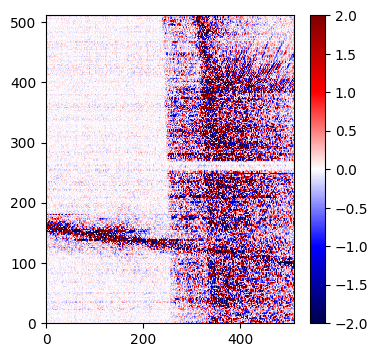

In [5]:
clip = 2
plt.figure(figsize=(4,4))
plt.imshow(noisy, origin='lower', cmap='seismic', aspect='auto', interpolation='none', vmin=-clip, vmax=clip)
plt.colorbar()
plt.show()

In [36]:
# file = 'south30_50Hz_UTC_20230409_090007.359.h5'

# data = h5py.File(dir + file)['DAS'][:].T

# data.shape

In [37]:
def bandpass_pad(x, low, high, fs, gutter, alpha=0.1):
    x = np.pad(x[None,:], ((0,0), (0,0), (gutter,gutter)), mode='constant', constant_values=0)

    band = [2 * low/fs, 2 * high/fs]
    b, a = signal.butter(2, band, btype="bandpass")
    window = signal.windows.tukey(x.shape[-1], alpha=alpha)
    x = signal.filtfilt(b, a, x * window, axis=-1)

    return x[..., gutter:-gutter]

In [38]:
def bandpass(x, low, high, fs):
    band = [2 * low/fs, 2 * high/fs]
    b, a = signal.butter(2, band, btype="bandpass")
    x = signal.filtfilt(b, a, x, axis=-1)

    return x

In [39]:
# filtered = bandpass(noisy, low=1.0, high=10.0, fs=50)
filtered = bandpass_pad(noisy, low=1.0, high=10.0, fs=50, gutter=1000)[0]

In [40]:
# filtered = noisy.copy()

In [41]:
median = np.median(filtered, axis=0, keepdims=True)
pre_processed = filtered - median

In [42]:
# noisy /= noisy.std()
# noisy = noisy / noisy.std(axis=1, keepdims=True)

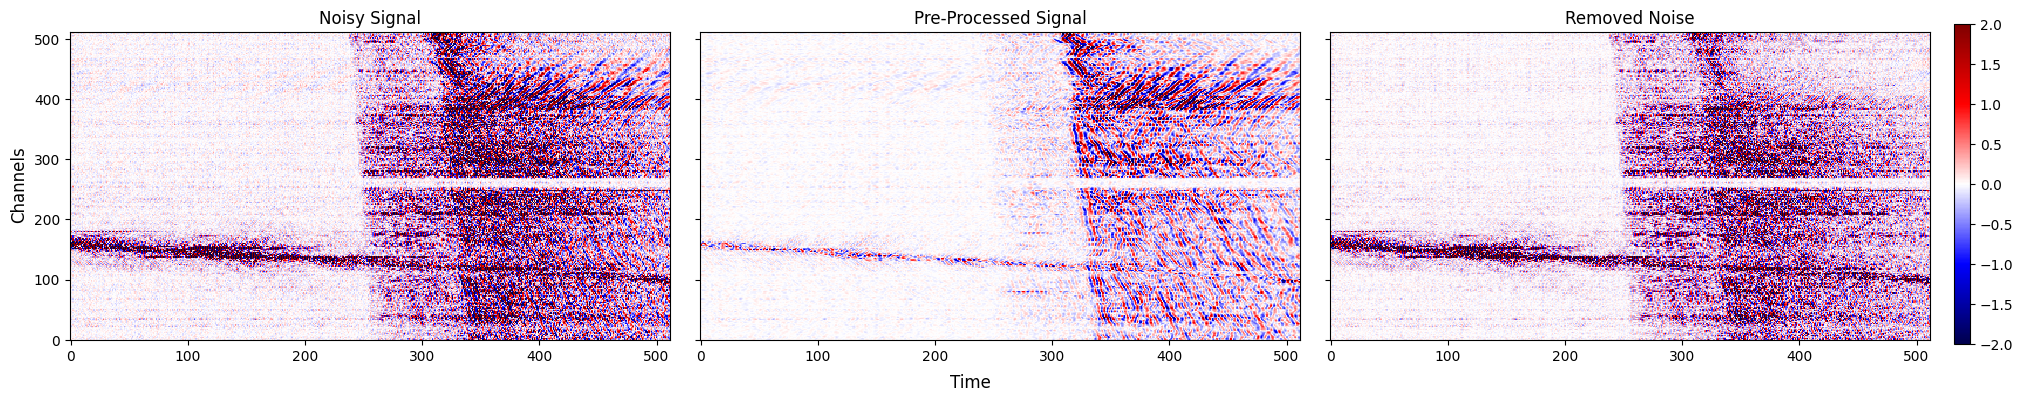

In [43]:
diff = noisy - pre_processed

# clip = np.percentile(noisy, 99.)
clip = 2

fig, axes = plt.subplots(1, 3, figsize=(24, 4), sharex=True, sharey=True)

im3 = axes[0].imshow(noisy, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('Noisy Signal')

axes[1].imshow(pre_processed, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('Pre-Processed Signal')

axes[2].imshow(diff, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[2].set_title('Removed Noise')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

In [44]:
# pre_processed = pre_processed / pre_processed.std(axis=1, keepdims=True)

In [45]:
# local normalization
# from scipy.ndimage import uniform_filter

# patch_size = 32

# local_mean = uniform_filter(pre_processed, size=patch_size) 
# local_var = uniform_filter(pre_processed**2, size=patch_size) - local_mean**2

# local_std = np.sqrt(np.maximum(local_var, 0))  # Ensure non-negative variance

# normalized = (pre_processed - 0) / (local_std + 1e-8)

In [46]:
from scipy.ndimage import uniform_filter1d

k = 32

local_mean = uniform_filter1d(pre_processed, size=k, axis=1, mode='nearest')

# Compute row-wise local variance and standard deviation
local_var = uniform_filter1d(pre_processed**2, size=k, axis=1, mode='nearest') - local_mean**2
local_std = np.sqrt(np.maximum(local_var, 0))  # Ensure non-negative variance

# Normalize the image: (I - local_mean) / (local_std + epsilon)
normalized = (pre_processed - 0) / (local_std + 1e-8)

In [47]:
# k = 32
# l = 1

# # Step 1: Apply a row-wise (1xk) uniform filter along columns
# local_mean = uniform_filter1d(pre_processed, size=k, axis=1, mode='nearest')

# # Step 2: Apply a column-wise (3x1) uniform filter along rows
# local_mean = uniform_filter1d(local_mean, size=l, axis=0, mode='nearest')

# # Compute local variance
# local_var = uniform_filter1d(pre_processed**2, size=k, axis=1, mode='nearest')
# local_var = uniform_filter1d(local_var, size=l, axis=0, mode='nearest')
# local_var -= local_mean**2

# # Compute local standard deviation
# local_std = np.sqrt(np.maximum(local_var, 0))  # Ensure non-negative variance

# # Normalize the image: (I - local_mean) / (local_std + epsilon)
# normalized = (pre_processed - 0) / (local_std + 1e-8)

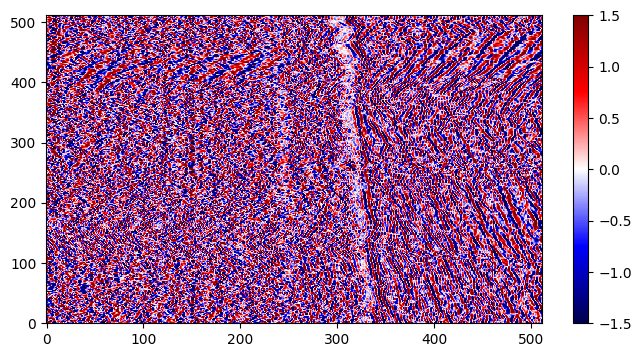

In [48]:
clip = 1.5
plt.figure(figsize=(8, 4))
plt.imshow(normalized, origin='lower', cmap='seismic', aspect='auto', interpolation='none', vmin=-clip, vmax=clip)
plt.colorbar()
plt.show()

In [49]:
y = torch.tensor(filtered.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

In [50]:
from models import UNetModECA, FC_ECA, FC_ECA1
from denoisers.dip import DIP, DDIP, SGDIP, PatchDIP, losses, schedules
from torchmetrics.image import PeakSignalNoiseRatio

# architectures
net1 = UNetModECA(in_ch=1, out_ch=1, hidden_ch=8, n_layers=4)
net2 = UNetModECA(in_ch=1, out_ch=1, hidden_ch=8, n_layers=2)
net2_freeze = UNetModECA(in_ch=1, out_ch=1, hidden_ch=8, n_layers=2, freeze=True)
net3 = FC_ECA(16*16)
net3_freeze = FC_ECA(16*16, freeze=True)
net4 = FC_ECA1(16*16)
net4_freeze = FC_ECA1(16*16, freeze=True)

# schedules
linear = schedules.Linear(1, 10)
cos = schedules.Cos(0.1, 0.9)

# losses
mse = losses.MSE()
mse_tv = losses.Compose(mse, losses.TV(), 0.0001)
nmse = losses.NMSE()
mse_ae = losses.Compose(mse, losses.AE(), 0.5)
mse_ae_linear = losses.Compose(mse, losses.AE(), linear)
nmse_ae = losses.Compose(nmse, losses.AE(), linear)

# variants
dip = DIP(net1, mse, max_epochs=2000, early_stopping=False)
# dip = DDIP(net1, mse, schedule=cos, max_epochs=300)
# dip = SGDIP(net1, mse_ae, max_epochs=500)
# dip = PatchDIP(net4, mse, 30, batch_size=1024, kurtosis_threshold=0.2)

options = {
    "mode": "local",
    "config": {
        "out_dir": "",
        "project": "",
        "entity": "",
        "group": "",
        "dataset": "",
        "denoiser_id": 0,
        "data_id": 0,
    },
    "metrics": {},
    "log_output": False,
}

Running: 0 - DIP - MSE - UNetMod ECA 


100%|██████████| 2000/2000 [01:07<00:00, 29.70it/s]


Summary: {'runtime': '00:01:07'}



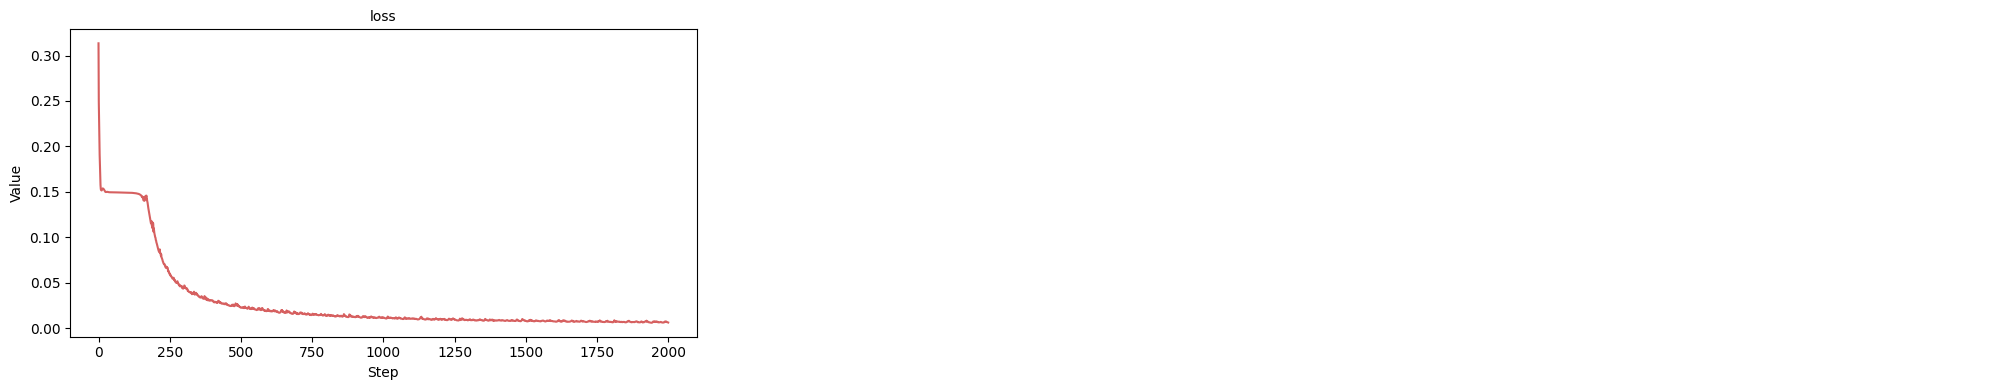

In [51]:
sgdip = SGDIP(net1, mse_ae.with_alpha(schedules.Linear(1, 10)), max_epochs=300, ratio=0.75, use_ref=True)  # ratio=1 for SOMF

x_hat, _, _ = dip.denoise(y, logging_options=options)

# x_hat, _, _ = sgdip.denoise(y, logging_options=options, init_state={"reference": y})
x_hat = x_hat.detach().clone().cpu() 

In [52]:
denoised = x_hat.squeeze().numpy()

# denoised = denoised*local_std #+ local_mean

diff = noisy - denoised

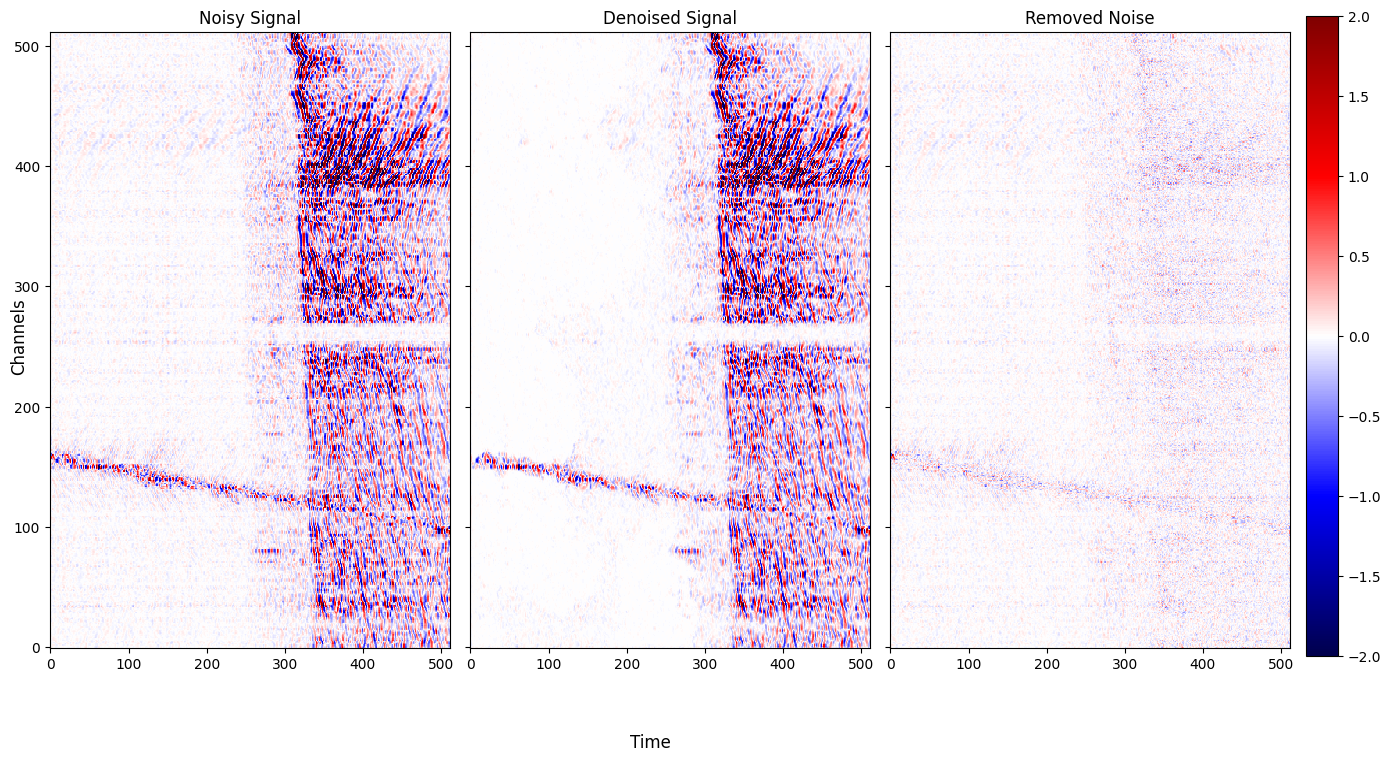

In [53]:
# clip = np.percentile(noisy, 80.)
clip = 2
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)

im3 = axes[0].imshow(filtered, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('Noisy Signal')

axes[1].imshow(denoised, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('Denoised Signal')

axes[2].imshow(filtered - denoised, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[2].set_title('Removed Noise')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

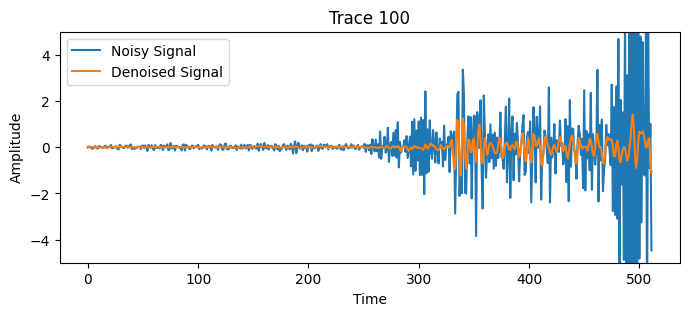

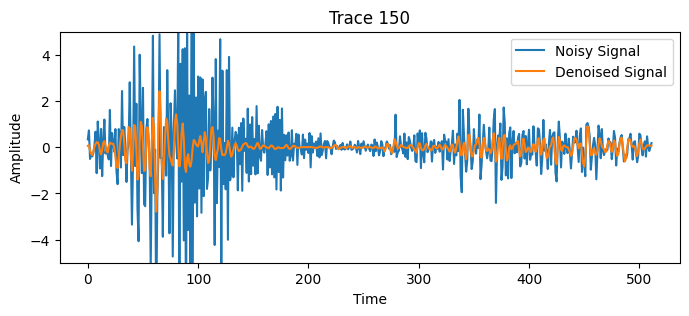

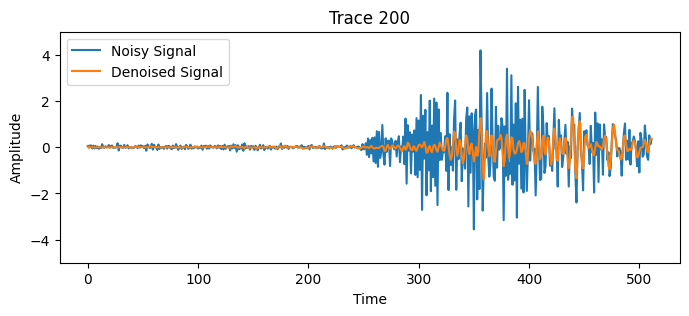

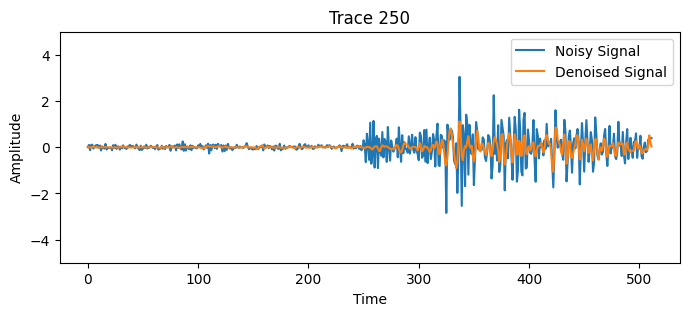

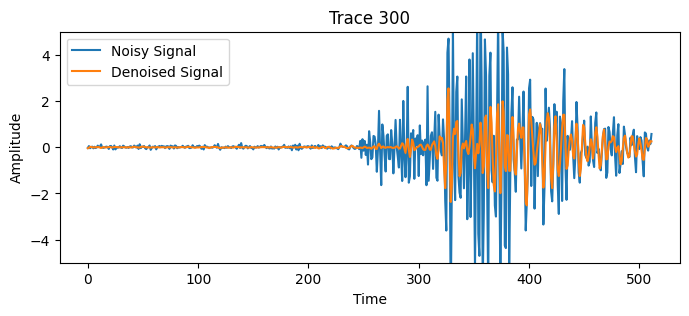

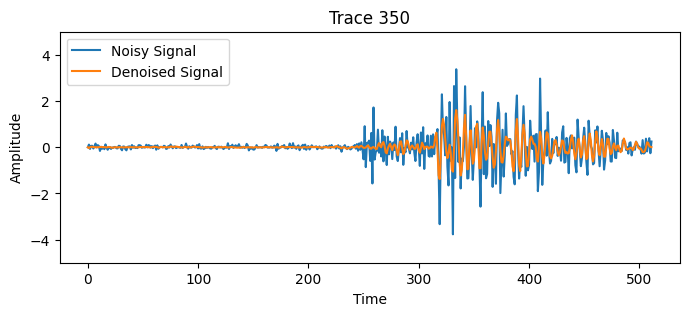

In [54]:
channels = [i for i in range(100, 400, 50)]

for channel in channels:
    denoised_trace = denoised[channel, :]
    noisy_trace = noisy[channel, :]

    plt.figure(figsize=(8, 3))
    plt.plot(noisy_trace, label='Noisy Signal')
    plt.plot(denoised_trace, label='Denoised Signal')
    plt.title(f'Trace {channel}')
    plt.ylabel('Amplitude')
    plt.xlabel('Time')
    plt.ylim(-5, 5)
    plt.legend()
    plt.show()

In [55]:
import pyseistr as ps

# BP
# idf = ps.bandpassc(noisy.T, 0.0005, 0, 200, 6, 6, 0, 0)
idf = ps.bandpassc(noisy.T, 0.02, 0, 200, 6, 6, 0, 0)

# SOMF
dip = ps.dip2dc(idf, 2, 10, 2, 0.01, 1, 0.000001, [50,50,1], 1)
idf = ps.somf2dc(idf, dip, 8, 2, 0.01, 1)

## FK
idf = idf - ps.fkdip(idf, 0.02)

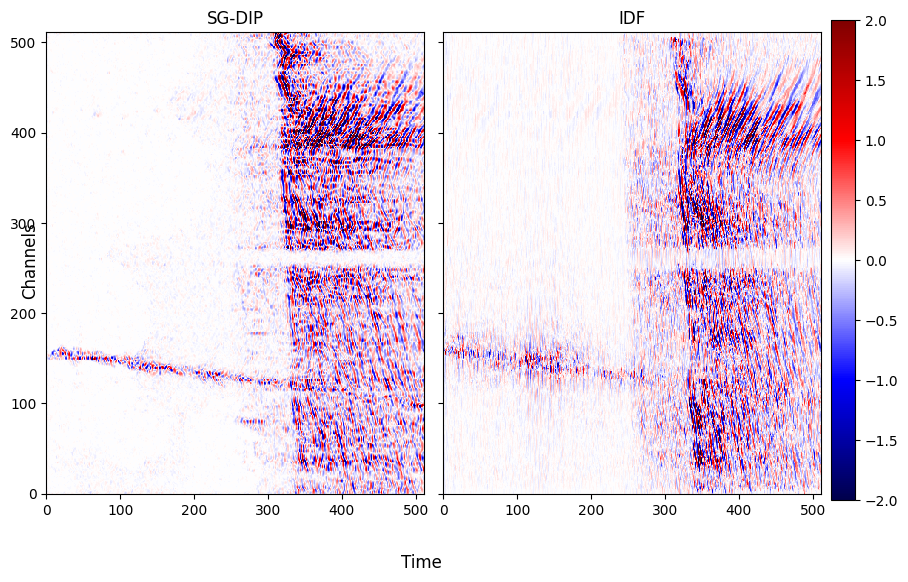

In [56]:
clip = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

im1 = axes[0].imshow(denoised, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('SG-DIP')

axes[1].imshow(idf.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('IDF')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

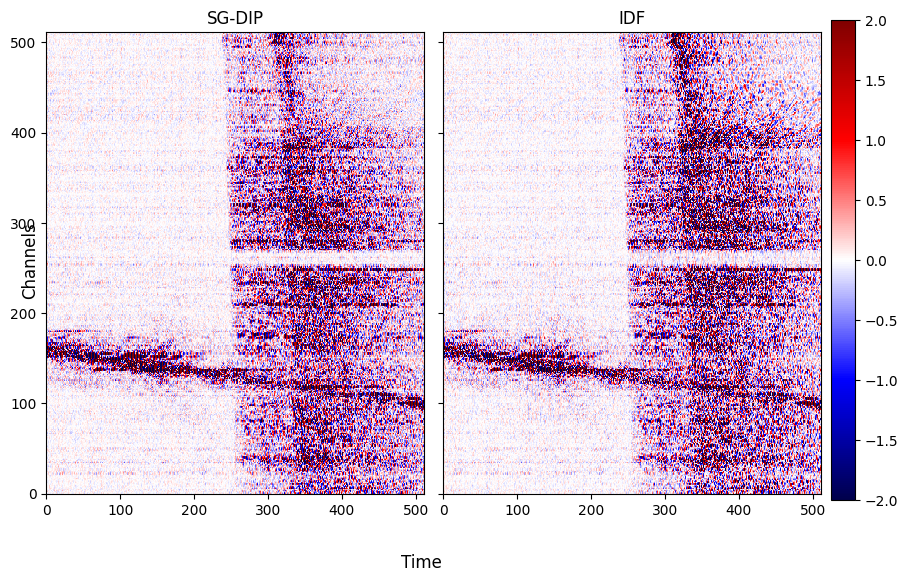

In [57]:
clip = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

im1 = axes[0].imshow(noisy - denoised, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('SG-DIP')

axes[1].imshow(noisy - idf.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('IDF')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

In [58]:
def xcorr(x, y):
    
    # FFT of x and conjugation
    X_bar = np.fft.rfft(x).conj()
    Y = np.fft.rfft(y)
    
    # Compute norm of data
    norm_x_sq = np.sum(x**2)
    norm_y_sq = np.sum(y**2)
    norm = np.sqrt(norm_x_sq * norm_y_sq)
    
    # Correlation coefficients
    R = np.fft.irfft(X_bar * Y) / norm
    
    # Return correlation coefficient
    return np.max(R)

def compute_xcorr_window(x):
    Nch = x.shape[0]
    Cxy = np.zeros((Nch, Nch)) * np.nan
    
    for i in range(Nch):
        for j in range(i):
            Cxy[i, j] = xcorr(x[i], x[j])
    
    return np.nanmean(Cxy)

def compute_moving_coherence(data, bin_size):
    
    N_ch = data.shape[0]
    
    cc = np.zeros(N_ch)
    
    for i in range(N_ch):
        start = max(0, i - bin_size // 2)
        stop = min(i + bin_size // 2, N_ch)
        ch_slice = slice(start, stop)
        cc[i] = compute_xcorr_window(data[ch_slice])
        
    return cc

In [59]:
cc_noisy = compute_moving_coherence(noisy, 11)
cc_denoised = compute_moving_coherence(denoised, 11)
cc_idf = compute_moving_coherence(idf.T, 11)

cc_gain_sg = cc_denoised / cc_noisy
cc_gain_idf = cc_idf / cc_noisy

cc_gain_sg.shape

(512,)

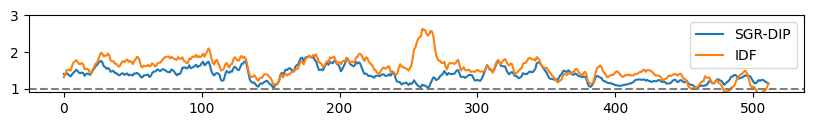

In [60]:
plt.figure(figsize=(10,1))
ax = plt.gca()
ax.set_ylim([0.9, 3])

plt.plot(cc_gain_sg, label="SGR-DIP")
plt.plot(cc_gain_idf, label="IDF")
plt.axhline(1, linestyle="dashed", color="gray")
plt.legend()
plt.show()

In [63]:
np.save('sissle_noisy.npy', noisy)
# np.save('sissle_idf.npy', idf)